In [2]:
from collections import Counter
import os
from glob import glob
import re
import numbers

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

## Create df with performance data

### Clone map

In [3]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,E,s1,P9855_2085_S108_L004_ac.txt,ss1
2,A,s2,P9855_2089_S112_L004_ac.txt,ss2
3,A,s3,P9855_2090_S113_L004_ac.txt,ss3
4,D,s4,P9855_2091_S114_L004_ac.txt,ss4
5,E,s5,P9855_2093_S116_L005_ac.txt,ss5
6,D,s6,P9855_2096_S119_L005_ac.txt,ss6
7,F,s7,P9855_2101_S124_L006_ac.txt,ss7
8,F,s8,P9855_2102_S125_L006_ac.txt,ss8
9,B,s9,P9855_2104_S127_L006_ac.txt,ss9


In [4]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [5]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

### Load info from mt-SCITE runs

In [6]:
scite_input_path = f'../../../mt-SCITE/mt-SCITE_output/P9855/stdout/'

scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))

# Get log likelihood scores and n trees
exp_std = []
lhood = []
n_trees = []

#for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
for filename in sorted(scite_stdout_filenames):
    print(filename)
    name = os.path.basename(filename).rsplit('.', 1)[0].rsplit('.', 1)[0]
    #print(name)
    exp_std.append(name)
    #print(files)
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
            #print(lhood)
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]
            #print(n_trees)
            

../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_4.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_5.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_6.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_7.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_8.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0001_9.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_1.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_10.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_2.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_3.stdout.txt
../../../mt-SCITE/mt-SCITE_output/P9855/stdout/0.0002_4.stdo

### Load info from pmats

In [7]:

pmat_input_path = f'../../data/P9855_matrix_output/'

pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))

pmat_names = []
n_pmat_rows = []

for filename in sorted(pmats):
#for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).rsplit('.', 1)[0]
    print(name)
    file = open(filename, "r")
    n = len(file.readlines())
    n_pmat_rows.append(n)
    pmat_names.append(name)

# store in a dict
pmat_info = {pmat_names[i]: n_pmat_rows[i] for i in range(len(pmat_names))}


0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001


In [8]:
pmat_info

{'0.0001': 176,
 '0.0002': 64,
 '0.0003': 40,
 '0.0004': 35,
 '0.0005': 34,
 '0.0006': 30,
 '0.0007': 28,
 '0.0008': 26,
 '0.0009': 24,
 '0.001': 24}

### Create df containing info from mt-SCITE and pmat

In [9]:
samples = 13

performance = pd.DataFrame(exp_std)
performance['lhood'] = lhood
performance['lhood'] = performance['lhood'].astype(float)

performance['n_trees'] = n_trees
performance['error_rate'] = performance[0].str.split('_').str.get(0)

performance = performance.rename(columns={0: 'run'})
performance = performance.set_index('run')

runs = performance.index.tolist()
performance = performance.sort_index()

performance['n_muts'] = performance['error_rate'].map(pmat_info)

performance['entries'] = performance['n_muts']*samples

performance['lhood_entries'] = performance['lhood']/performance['entries']

In [10]:
performance

,lhood,n_trees,error_rate,n_muts,entries,lhood_entries
run,,,,,,
0.0001_1,-1530.050214,1,0.0001,176,2288,-0.668728
0.0001_10,-1503.019453,3,0.0001,176,2288,-0.656914
0.0001_2,-1496.971942,10,0.0001,176,2288,-0.654271
0.0001_3,-1542.329910,84,0.0001,176,2288,-0.674095
0.0001_4,-1495.876259,2,0.0001,176,2288,-0.653792
...,...,...,...,...,...,...
0.001_5,-31.430335,18,0.001,24,312,-0.100738
0.001_6,-31.430335,35,0.001,24,312,-0.100738
0.001_7,-31.430335,4,0.001,24,312,-0.100738


### Read trees

In [11]:
MAX_TREES_PER_ERROR_RATE = 100
all_trees = {}
for run, n in zip(runs, n_trees):
    all_trees[run] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        #print(n)
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855/{run}_map{idx}.gv' 
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[run].append(tree)
        #print(error_rate)

In [12]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_49917/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


# Avg purity of nodes with >1 sample

In [13]:
import warnings
warnings.filterwarnings('ignore')

performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    #n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        #print(p)
        
        # exclude mutations shared by all clones
        p = p.T
        p = p.mask((p.A > 0) & (p.B > 0) & (p.C > 0) & (p.D > 0) & (p.E > 0) & (p.F > 0))
        p = p.dropna().T
        
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 17

!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 174
!! possible mutation in a leaf: not found 48
!! possible mutation in a leaf: not found 46


!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 80


In [14]:
performance

,lhood,n_trees,error_rate,n_muts,entries,lhood_entries,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample
run,,,,,,,,
0.0001_1,-1530.050214,1,0.0001,176,2288,-0.668728,0.750427,0.630769
0.0001_10,-1503.019453,3,0.0001,176,2288,-0.656914,0.728706,0.559322
0.0001_2,-1496.971942,10,0.0001,176,2288,-0.654271,0.802520,0.649123
0.0001_3,-1542.329910,84,0.0001,176,2288,-0.674095,0.803981,0.666667
0.0001_4,-1495.876259,2,0.0001,176,2288,-0.653792,0.809641,0.703704
...,...,...,...,...,...,...,...,...
0.001_5,-31.430335,18,0.001,24,312,-0.100738,0.924868,0.904762
0.001_6,-31.430335,35,0.001,24,312,-0.100738,0.924868,0.904762
0.001_7,-31.430335,4,0.001,24,312,-0.100738,0.924868,0.904762


# Plots

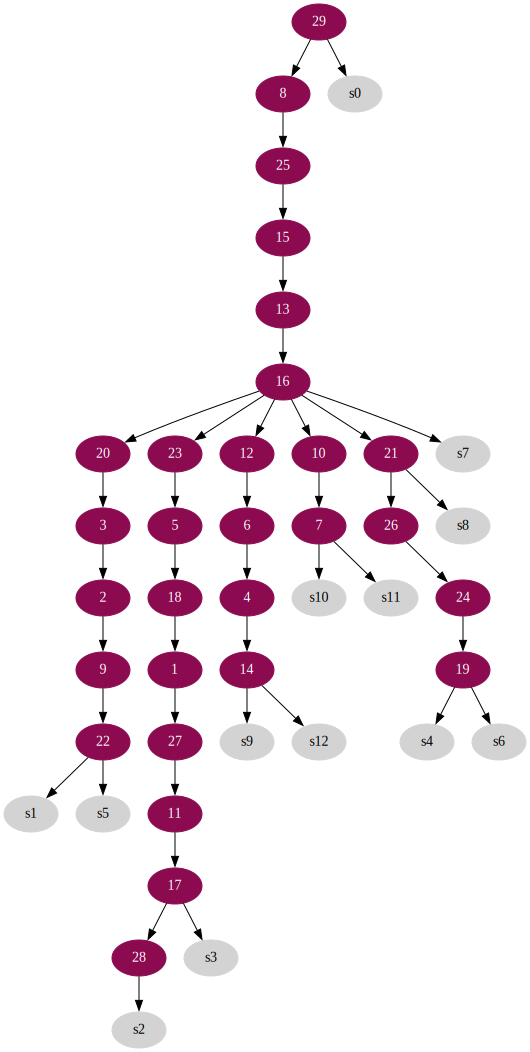

In [15]:
Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855/0.0007_1_map5.gv')

In [16]:
# Plot a tree
# Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/0.0005_10_map0.gv')

In [17]:
#pd.set_option('display.max_rows', None)
#performance

## Tree Likelihood

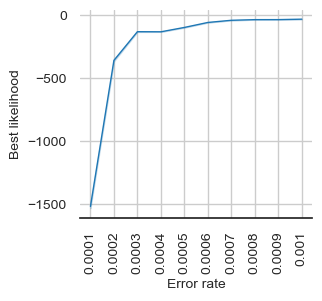

In [19]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood')
    plt.xlabel('Error rate')

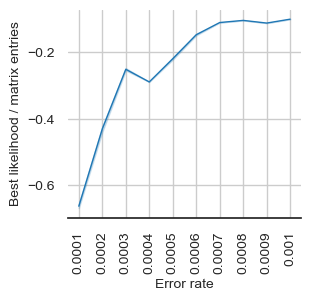

In [93]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="lhood_entries", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood / matrix entries')
    plt.xlabel('Error rate')

plt.savefig(f'../../data/P9855_figures/lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/P9855_figures/lhood_entries.jpg', dpi=300, bbox_inches='tight', transparent=True)

## Average purity

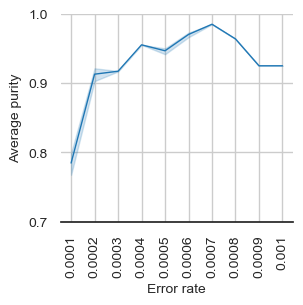

In [97]:

with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="error_rate", y="avg_purity_more_than_one_sample", markersize=4, lw=1)
    ax.set_ylim(0.7, 1.0)
    plt.grid(axis='both')
    plt.xticks(rotation=90)
    plt.ylabel('Average purity')
    plt.xlabel('Error rate')
    
    
plt.savefig(f'../../data/P9855_figures/avg_purity.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/P9855_figures/avg_purity.jpg', dpi=300, bbox_inches='tight', transparent=True)

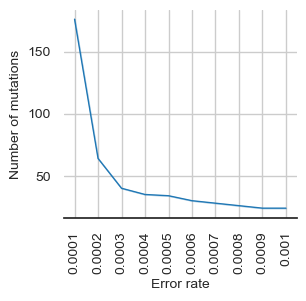

In [31]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="n_muts", lw=1) #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Number of mutations')
    plt.xlabel('Error rate')
    plt.savefig(f'../../data/P9855_figures/n_muts.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(f'../../data/P9855_figures/n_muts.jpg', dpi=300, bbox_inches='tight', transparent=True)

In [22]:
performance.rename(columns={'n trees': 'n_trees'}, inplace=True)

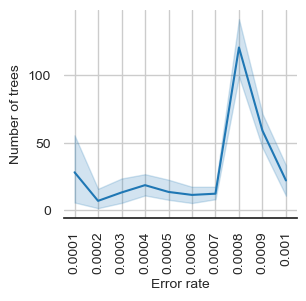

In [26]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):

    sns.lineplot(data=performance.reset_index(), x='error_rate', y="n_trees")

    plt.grid(axis='both')
    #plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Number of trees')
    plt.xticks(rotation = 90)
    
    plt.savefig(f'../../data/P9855_figures/n_trees.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(f'../../data/P9855_figures/n_trees.jpg', dpi=300, bbox_inches='tight', transparent=True)